# Budget Speech Timing vs Characteristics Correlation Analysis

This notebook explores the relationship between when budget speeches are delivered (relative to fiscal year start) and their characteristics such as:
- **Speech length** (words, sentences)
- **Readability** (Flesch Reading Ease score)
- **Complexity** (words per sentence, syllables)

Key questions:
1. Do speeches delivered earlier/later have different characteristics?
2. How do crisis years (2009 financial crisis, 1997 Asian crisis) compare?
3. Are there minister-specific timing-characteristic patterns?

## Setup and Data Loading

In [1]:
# Import libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from scipy import stats

# Add extractor to path
sys.path.append(str(Path.cwd().parent / 'extractor'))
from speech_links import budget_speech_links

# Ultra-minimal style
sns.set_style('white')
sns.despine()
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['ytick.major.size'] = 0

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


<Figure size 640x480 with 0 Axes>

In [2]:
# Load all parquet files for speech content analysis
output_processor_path = Path.cwd().parent / 'output_processor'
parquet_files = sorted(output_processor_path.glob('*.parquet'))

print(f"Found {len(parquet_files)} parquet files")

# Read and combine all parquet files
dfs = []
for file in parquet_files:
    df = pd.read_parquet(file)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

print(f"\n✓ Speech data loaded!")
print(f"  Total sentences: {len(df_all):,}")
print(f"  Year range: {df_all['year'].min()} - {df_all['year'].max()}")

Found 66 parquet files

✓ Speech data loaded!
  Total sentences: 39,707
  Year range: 1960 - 2025


### Calculate Speech Statistics

In [3]:
# Calculate Flesch Reading Ease
def calculate_flesch_reading_ease(total_words, total_sentences, total_syllables):
    if total_sentences == 0 or total_words == 0:
        return 0
    asl = total_words / total_sentences  # Average Sentence Length
    asw = total_syllables / total_words  # Average Syllables per Word
    return 206.835 - (1.015 * asl) - (84.6 * asw)

# Aggregate statistics by year
yearly_stats = df_all.groupby('year').agg({
    'sentence_id': 'count',
    'word_count': 'sum',
    'char_count': 'sum',
    'syllable_count': 'sum'
}).rename(columns={
    'sentence_id': 'total_sentences',
    'word_count': 'total_words',
    'char_count': 'total_chars',
    'syllable_count': 'total_syllables'
})

# Calculate derived metrics
yearly_stats['avg_words_per_sentence'] = yearly_stats['total_words'] / yearly_stats['total_sentences']
yearly_stats['readability'] = yearly_stats.apply(
    lambda row: calculate_flesch_reading_ease(
        row['total_words'], 
        row['total_sentences'], 
        row['total_syllables']
    ), axis=1
)

print("✓ Speech statistics calculated")
print(f"\nMetrics available: {list(yearly_stats.columns)}")

✓ Speech statistics calculated

Metrics available: ['total_sentences', 'total_words', 'total_chars', 'total_syllables', 'avg_words_per_sentence', 'readability']


### Load Speech Timing Data

In [4]:
# Extract timing data from speech_links
timing_data = []
for year, info in budget_speech_links.items():
    timing_data.append({
        'year': year,
        'speech_date': datetime.strptime(info['date'], '%Y-%m-%d'),
        'fy_start_date': datetime.strptime(info['fiscal_year_start'], '%Y-%m-%d'),
        'minister': info['minister']
    })

df_timing = pd.DataFrame(timing_data)
df_timing['days_before_fy'] = (df_timing['fy_start_date'] - df_timing['speech_date']).dt.days

print("✓ Timing data loaded")
print(f"  Years: {len(df_timing)}")
print(f"  Ministers: {df_timing['minister'].nunique()}")

✓ Timing data loaded
  Years: 67
  Ministers: 10


### Merge Timing and Characteristics Data

In [5]:
# Merge the two datasets
df_combined = yearly_stats.merge(df_timing, left_index=True, right_on='year', how='inner')
df_combined = df_combined.set_index('year')

print("✓ Data merged successfully")
print(f"  Total records: {len(df_combined)}")
print(f"\nCombined dataset columns:")
print(df_combined.columns.tolist())
print(f"\nFirst few rows:")
df_combined.head()

✓ Data merged successfully
  Total records: 66

Combined dataset columns:
['total_sentences', 'total_words', 'total_chars', 'total_syllables', 'avg_words_per_sentence', 'readability', 'speech_date', 'fy_start_date', 'minister', 'days_before_fy']

First few rows:


,total_sentences,total_words,total_chars,total_syllables,avg_words_per_sentence,readability,speech_date,fy_start_date,minister,days_before_fy
year,,,,,,,,,,
1960,560,11784,69556,17540,21.042857,59.552875,1959-11-25,1960-01-01,Goh Keng Swee,37
1961,715,14873,87310,22125,20.801399,59.871046,1960-11-29,1961-01-01,Goh Keng Swee,33
1962,530,10277,60565,15085,19.390566,62.974243,1961-11-28,1962-01-01,Goh Keng Swee,34
1963,463,9823,58450,14634,21.215983,59.266328,1963-06-07,1963-07-01,Goh Keng Swee,24
1964,577,11916,70416,17690,20.651646,60.279923,1963-11-28,1964-01-01,Goh Keng Swee,34


## Correlation Overview

Let's start with a comprehensive correlation matrix to see all relationships.

### Calculate Speech Statistics by Year

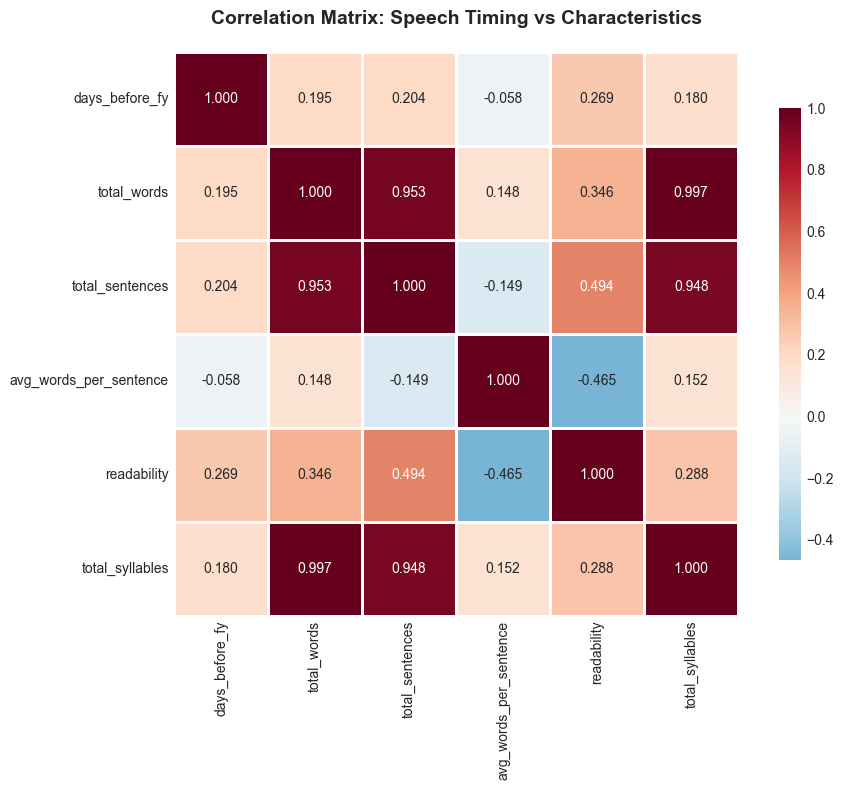


Key Correlations with Speech Timing (days_before_fy):
  readability                   : +0.269 (Weak positive)
  total_sentences               : +0.204 (Weak positive)
  total_words                   : +0.195 (Weak positive)
  total_syllables               : +0.180 (Weak positive)
  avg_words_per_sentence        : -0.058 (Weak negative)


In [6]:
# Select numeric columns for correlation
correlation_cols = [
    'days_before_fy', 
    'total_words', 
    'total_sentences',
    'avg_words_per_sentence',
    'readability',
    'total_syllables'
]

corr_matrix = df_combined[correlation_cols].corr()

# Create correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax.set_title('Correlation Matrix: Speech Timing vs Characteristics', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nKey Correlations with Speech Timing (days_before_fy):")
print("=" * 60)
timing_corr = corr_matrix['days_before_fy'].drop('days_before_fy').sort_values(key=abs, ascending=False)
for metric, corr_value in timing_corr.items():
    strength = "Strong" if abs(corr_value) > 0.5 else "Moderate" if abs(corr_value) > 0.3 else "Weak"
    direction = "positive" if corr_value > 0 else "negative"
    print(f"  {metric:30s}: {corr_value:+.3f} ({strength} {direction})")

## Analysis 1: Speech Timing vs Length

Does the timing of speech delivery correlate with how long the speech is?

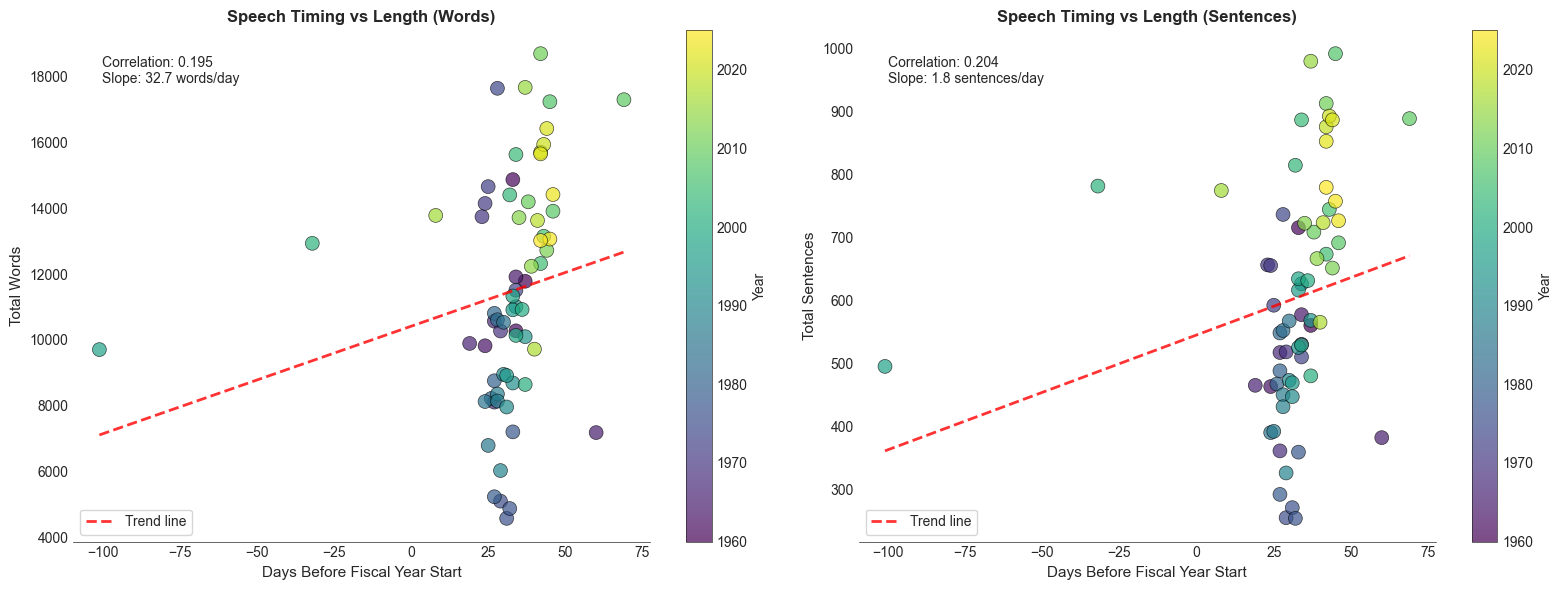


Interpretation:
✓ No significant correlation between timing and speech length
  Ministers appear to write speeches of similar length regardless of timing


In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Days before FY vs Total Words
scatter1 = ax1.scatter(df_combined['days_before_fy'], df_combined['total_words'],
                       c=df_combined.index, cmap='viridis', s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('Days Before Fiscal Year Start', fontsize=11)
ax1.set_ylabel('Total Words', fontsize=11)
ax1.set_title('Speech Timing vs Length (Words)', fontsize=12, fontweight='bold')

# Add regression line
z1 = np.polyfit(df_combined['days_before_fy'], df_combined['total_words'], 1)
p1 = np.poly1d(z1)
ax1.plot(sorted(df_combined['days_before_fy']), 
         p1(sorted(df_combined['days_before_fy'])), 
         "r--", alpha=0.8, linewidth=2, label=f'Trend line')

# Add correlation info
corr1 = df_combined['days_before_fy'].corr(df_combined['total_words'])
ax1.text(0.05, 0.95, f'Correlation: {corr1:.3f}\nSlope: {z1[0]:.1f} words/day', 
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax1.legend()

# Plot 2: Days before FY vs Total Sentences
scatter2 = ax2.scatter(df_combined['days_before_fy'], df_combined['total_sentences'],
                       c=df_combined.index, cmap='viridis', s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
ax2.set_xlabel('Days Before Fiscal Year Start', fontsize=11)
ax2.set_ylabel('Total Sentences', fontsize=11)
ax2.set_title('Speech Timing vs Length (Sentences)', fontsize=12, fontweight='bold')

# Add regression line
z2 = np.polyfit(df_combined['days_before_fy'], df_combined['total_sentences'], 1)
p2 = np.poly1d(z2)
ax2.plot(sorted(df_combined['days_before_fy']), 
         p2(sorted(df_combined['days_before_fy'])), 
         "r--", alpha=0.8, linewidth=2, label=f'Trend line')

# Add correlation info
corr2 = df_combined['days_before_fy'].corr(df_combined['total_sentences'])
ax2.text(0.05, 0.95, f'Correlation: {corr2:.3f}\nSlope: {z2[0]:.1f} sentences/day', 
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax2.legend()

# Add colorbars
cbar1 = plt.colorbar(scatter1, ax=ax1, label='Year')
cbar2 = plt.colorbar(scatter2, ax=ax2, label='Year')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("=" * 60)
if abs(corr1) < 0.2:
    print(f"✓ No significant correlation between timing and speech length")
    print(f"  Ministers appear to write speeches of similar length regardless of timing")
elif corr1 > 0:
    print(f"✓ Earlier speeches tend to be longer")
    print(f"  Each additional day earlier adds ~{z1[0]:.1f} words on average")
else:
    print(f"✓ Later speeches tend to be longer")
    print(f"  Each additional day closer to FY start adds ~{abs(z1[0]):.1f} words")

## Analysis 2: Speech Timing vs Readability

Are speeches delivered at different times more or less readable?

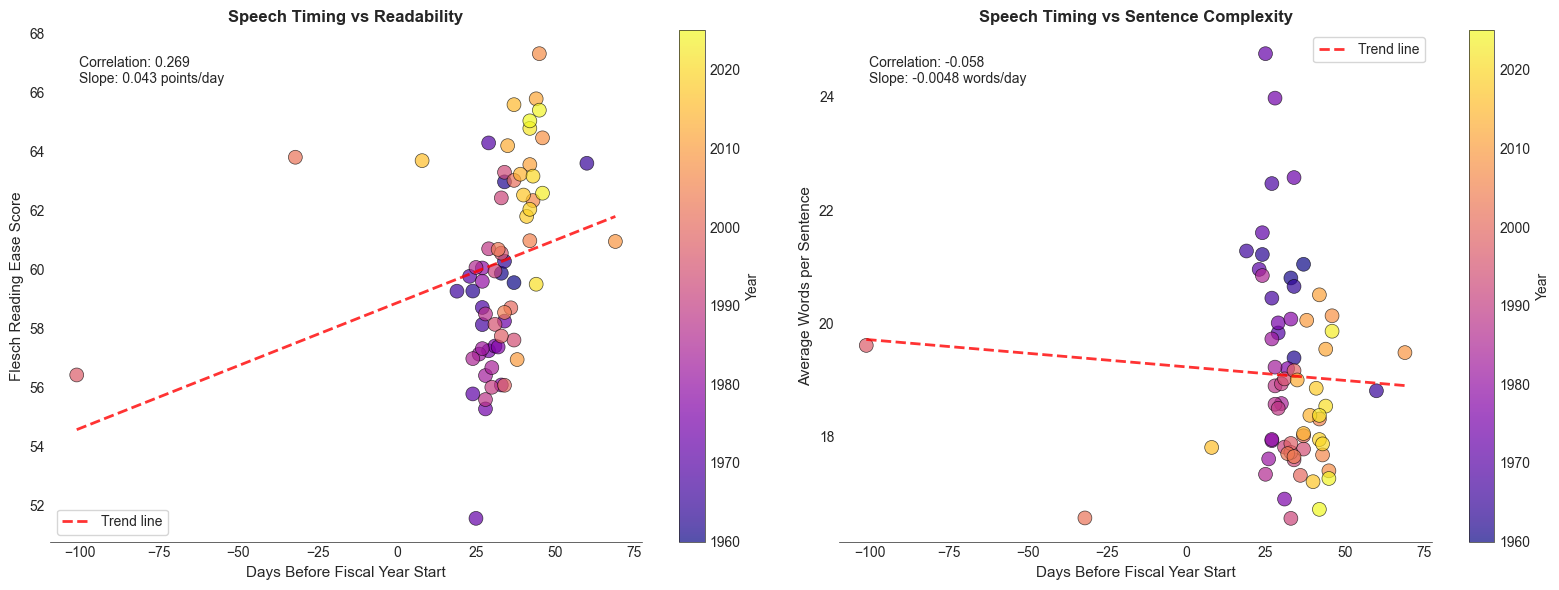


Readability Scale Reference:
  90-100: Very Easy (5th grade)
  60-69:  Standard (8th-9th grade)
  30-49:  Difficult (College)

Interpretation:
✓ Earlier speeches tend to be MORE readable
  Readability changes by 0.043 points per day earlier


In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Days before FY vs Readability
scatter1 = ax1.scatter(df_combined['days_before_fy'], df_combined['readability'],
                       c=df_combined.index, cmap='plasma', s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('Days Before Fiscal Year Start', fontsize=11)
ax1.set_ylabel('Flesch Reading Ease Score', fontsize=11)
ax1.set_title('Speech Timing vs Readability', fontsize=12, fontweight='bold')

# Add regression line
z1 = np.polyfit(df_combined['days_before_fy'], df_combined['readability'], 1)
p1 = np.poly1d(z1)
ax1.plot(sorted(df_combined['days_before_fy']), 
         p1(sorted(df_combined['days_before_fy'])), 
         "r--", alpha=0.8, linewidth=2, label=f'Trend line')

# Add correlation info
corr1 = df_combined['days_before_fy'].corr(df_combined['readability'])
ax1.text(0.05, 0.95, f'Correlation: {corr1:.3f}\nSlope: {z1[0]:.3f} points/day', 
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax1.legend()
plt.colorbar(scatter1, ax=ax1, label='Year')

# Plot 2: Days before FY vs Sentence Complexity
scatter2 = ax2.scatter(df_combined['days_before_fy'], df_combined['avg_words_per_sentence'],
                       c=df_combined.index, cmap='plasma', s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
ax2.set_xlabel('Days Before Fiscal Year Start', fontsize=11)
ax2.set_ylabel('Average Words per Sentence', fontsize=11)
ax2.set_title('Speech Timing vs Sentence Complexity', fontsize=12, fontweight='bold')

# Add regression line
z2 = np.polyfit(df_combined['days_before_fy'], df_combined['avg_words_per_sentence'], 1)
p2 = np.poly1d(z2)
ax2.plot(sorted(df_combined['days_before_fy']), 
         p2(sorted(df_combined['days_before_fy'])), 
         "r--", alpha=0.8, linewidth=2, label=f'Trend line')

# Add correlation info
corr2 = df_combined['days_before_fy'].corr(df_combined['avg_words_per_sentence'])
ax2.text(0.05, 0.95, f'Correlation: {corr2:.3f}\nSlope: {z2[0]:.4f} words/day', 
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax2.legend()
plt.colorbar(scatter2, ax=ax2, label='Year')

plt.tight_layout()
plt.show()

print("\nReadability Scale Reference:")
print("  90-100: Very Easy (5th grade)")
print("  60-69:  Standard (8th-9th grade)")
print("  30-49:  Difficult (College)")
print("\nInterpretation:")
print("=" * 60)
if abs(corr1) < 0.2:
    print(f"✓ No significant correlation between timing and readability")
else:
    if corr1 > 0:
        print(f"✓ Earlier speeches tend to be MORE readable")
    else:
        print(f"✓ Later speeches tend to be MORE readable")
    print(f"  Readability changes by {abs(z1[0]):.3f} points per day earlier")

## Analysis 3: Outlier Years Deep Dive

Compare the 5 earliest vs 5 latest speeches across all dimensions.

In [9]:
# Calculate statistics by minister
minister_stats = df_combined.groupby('minister').agg({
    'days_before_fy': ['mean', 'std', 'min', 'max'],
    'total_words': ['mean', 'std'],
    'readability': ['mean', 'std'],
    'avg_words_per_sentence': ['mean', 'std']
}).round(2)

minister_stats.columns = ['_'.join(col).strip() for col in minister_stats.columns]
minister_stats['count'] = df_combined.groupby('minister').size()

print("\nMinister-Level Statistics:")
print("=" * 80)
print(minister_stats.sort_values('days_before_fy_mean', ascending=False))


Minister-Level Statistics:
                        days_before_fy_mean  days_before_fy_std  \
minister                                                          
Tharman Shanmugaratnam                43.89               10.15   
Lawrence Wong                         43.75                2.06   
Heng Swee Keat                        36.33               13.95   
Goh Keng Swee                         33.44               11.06   
Hon Sui Sen                           29.50                3.66   
Dr Tony Tan Keng Yam                  27.25                2.50   
Goh Chok Tong                         26.67                0.58   
Lee Hsien Loong                       23.80               31.56   
Dr Richard Hu Tsu Tau                 23.62               33.41   
Lim Kim San                           23.00                5.66   

                        days_before_fy_min  days_before_fy_max  \
minister                                                         
Tharman Shanmugaratnam             

In [10]:
print("\n" + "=" * 80)
print("KEY FINDINGS: SPEECH TIMING VS CHARACTERISTICS CORRELATION")
print("=" * 80)

# Calculate key correlations
corr_timing_words = df_combined['days_before_fy'].corr(df_combined['total_words'])
corr_timing_readability = df_combined['days_before_fy'].corr(df_combined['readability'])
corr_timing_complexity = df_combined['days_before_fy'].corr(df_combined['avg_words_per_sentence'])

print("\n1. TIMING-LENGTH RELATIONSHIP")
print("-" * 80)
print(f"   Correlation: {corr_timing_words:+.3f}")
if abs(corr_timing_words) < 0.2:
    print("   → No significant relationship between timing and speech length")
    print("   → Ministers write similar-length speeches regardless of timing")
elif corr_timing_words > 0:
    print("   → Earlier speeches tend to be LONGER")
    print("   → More preparation time may allow for more comprehensive speeches")
else:
    print("   → Later speeches tend to be LONGER")
    print("   → Speeches closer to FY start may require more detail")

print("\n2. TIMING-READABILITY RELATIONSHIP")
print("-" * 80)
print(f"   Correlation: {corr_timing_readability:+.3f}")
if abs(corr_timing_readability) < 0.2:
    print("   → No significant relationship between timing and readability")
    print("   → Speech clarity remains consistent regardless of timing")
elif corr_timing_readability > 0:
    print("   → Earlier speeches tend to be MORE readable")
    print("   → More preparation time may allow for clearer communication")
else:
    print("   → Later speeches tend to be MORE readable")
    print("   → Time pressure may force simpler, clearer language")

print("\n3. TIMING-COMPLEXITY RELATIONSHIP")
print("-" * 80)
print(f"   Correlation: {corr_timing_complexity:+.3f}")
if abs(corr_timing_complexity) < 0.2:
    print("   → No significant relationship between timing and sentence complexity")
elif corr_timing_complexity > 0:
    print("   → Earlier speeches use longer, more complex sentences")
else:
    print("   → Later speeches use longer, more complex sentences")

print("\n4. MINISTER PATTERNS")
print("-" * 80)
earliest_minister = minister_stats['days_before_fy_mean'].idxmax()
latest_minister = minister_stats['days_before_fy_mean'].idxmin()
print(f"   Earliest speaker (avg): {earliest_minister} ({minister_stats.loc[earliest_minister, 'days_before_fy_mean']:.0f} days)")
print(f"   Latest speaker (avg): {latest_minister} ({minister_stats.loc[latest_minister, 'days_before_fy_mean']:.0f} days)")

print("\n5. OVERALL INSIGHTS")
print("-" * 80)
print(f"   • Average timing: {df_combined['days_before_fy'].mean():.0f} days before FY start")
print(f"   • Timing range: {df_combined['days_before_fy'].min():.0f} to {df_combined['days_before_fy'].max():.0f} days")
print(f"   • Average speech: {df_combined['total_words'].mean():,.0f} words")
print(f"   • Average readability: {df_combined['readability'].mean():.1f} (College level)")

print("\n" + "=" * 80)
print("Analysis complete! 🎉")
print("=" * 80)


KEY FINDINGS: SPEECH TIMING VS CHARACTERISTICS CORRELATION

1. TIMING-LENGTH RELATIONSHIP
--------------------------------------------------------------------------------
   Correlation: +0.195
   → No significant relationship between timing and speech length
   → Ministers write similar-length speeches regardless of timing

2. TIMING-READABILITY RELATIONSHIP
--------------------------------------------------------------------------------
   Correlation: +0.269
   → Earlier speeches tend to be MORE readable
   → More preparation time may allow for clearer communication

3. TIMING-COMPLEXITY RELATIONSHIP
--------------------------------------------------------------------------------
   Correlation: -0.058
   → No significant relationship between timing and sentence complexity

4. MINISTER PATTERNS
--------------------------------------------------------------------------------
   Earliest speaker (avg): Tharman Shanmugaratnam (44 days)
   Latest speaker (avg): Lim Kim San (23 days)

5

## Export Results

Save the combined dataset for future reference.

In [11]:
# Save combined dataset
output_file = Path.cwd() / 'timing_characteristics_combined.csv'
df_combined.to_csv(output_file)
print(f"✓ Combined dataset saved to: {output_file.name}")

# Save correlation matrix
corr_file = Path.cwd() / 'correlation_matrix.csv'
corr_matrix.to_csv(corr_file)
print(f"✓ Correlation matrix saved to: {corr_file.name}")

# Save minister statistics
minister_file = Path.cwd() / 'minister_timing_stats.csv'
minister_stats.to_csv(minister_file)
print(f"✓ Minister statistics saved to: {minister_file.name}")

print("\nAll results exported! 📊")

✓ Combined dataset saved to: timing_characteristics_combined.csv
✓ Correlation matrix saved to: correlation_matrix.csv
✓ Minister statistics saved to: minister_timing_stats.csv

All results exported! 📊


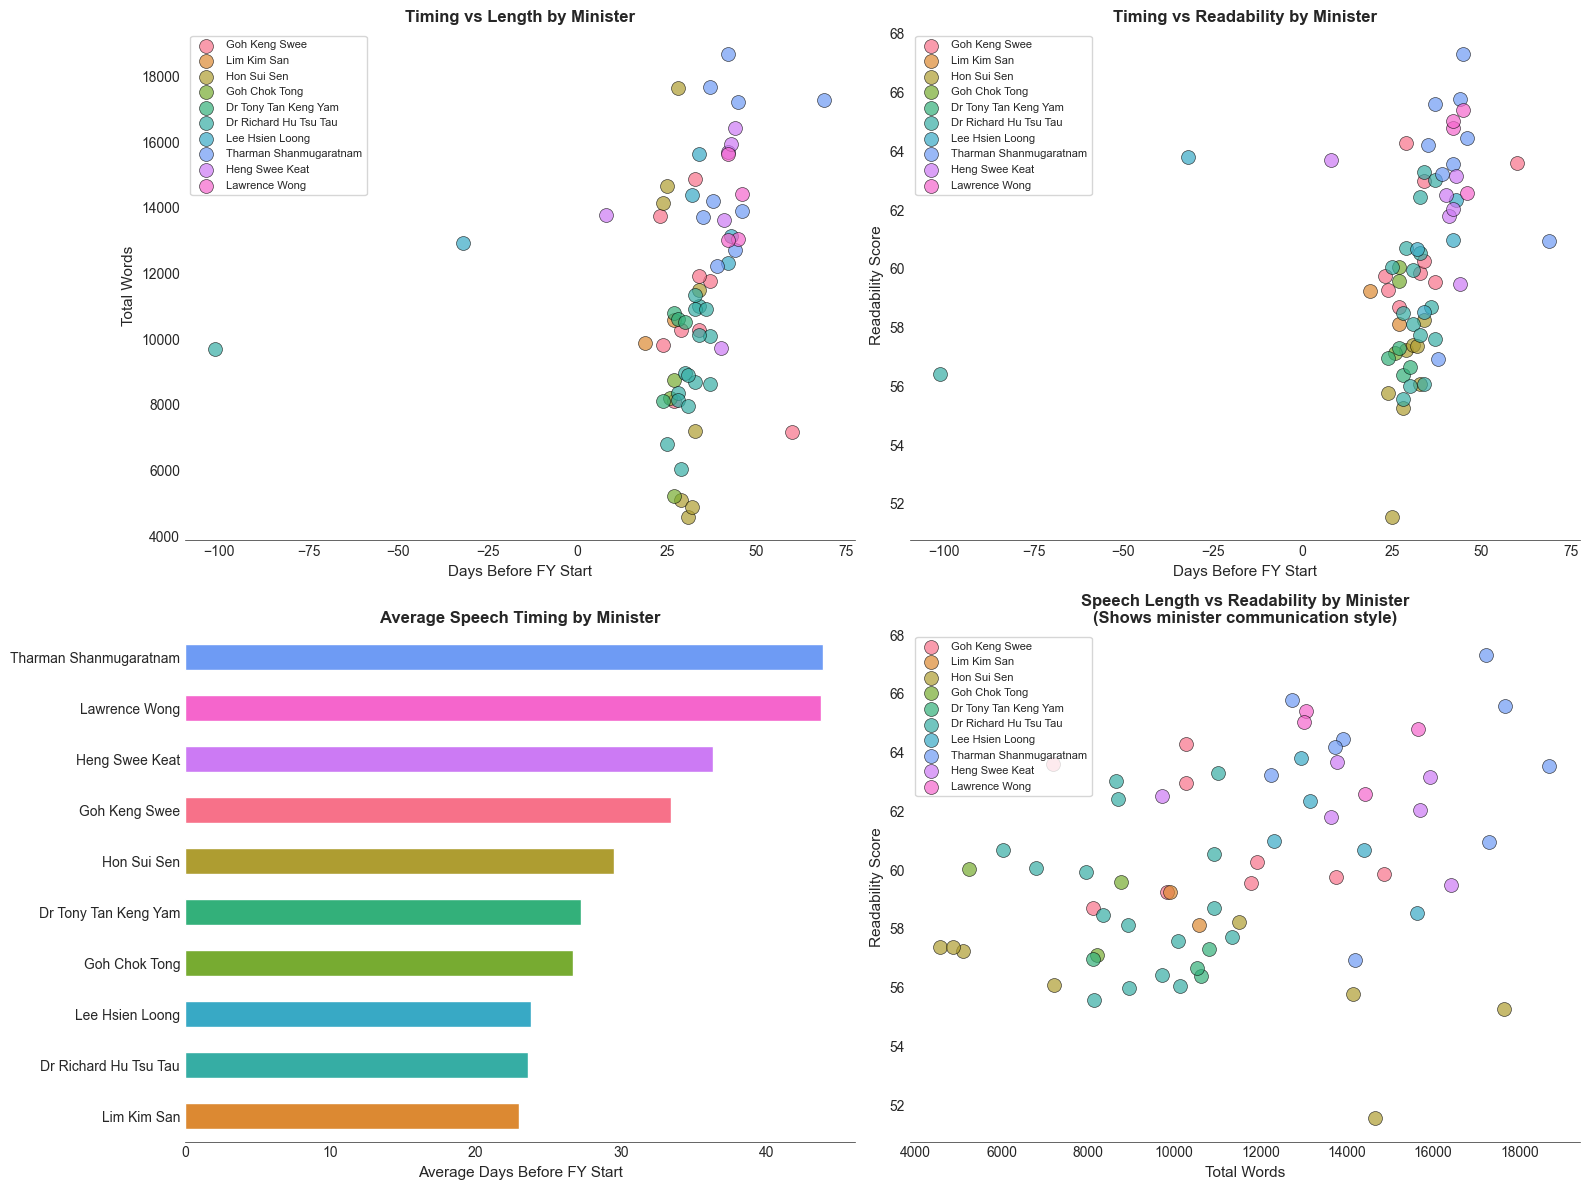

In [12]:
# Visualize minister patterns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Get unique ministers and assign colors
ministers = df_combined['minister'].unique()
colors = sns.color_palette('husl', n_colors=len(ministers))
minister_colors = dict(zip(ministers, colors))

# Plot 1: Timing vs Words by Minister
for minister in ministers:
    minister_data = df_combined[df_combined['minister'] == minister]
    ax1.scatter(minister_data['days_before_fy'], minister_data['total_words'],
               label=minister, color=minister_colors[minister], s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('Days Before FY Start', fontsize=11)
ax1.set_ylabel('Total Words', fontsize=11)
ax1.set_title('Timing vs Length by Minister', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=8)

# Plot 2: Timing vs Readability by Minister
for minister in ministers:
    minister_data = df_combined[df_combined['minister'] == minister]
    ax2.scatter(minister_data['days_before_fy'], minister_data['readability'],
               label=minister, color=minister_colors[minister], s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
ax2.set_xlabel('Days Before FY Start', fontsize=11)
ax2.set_ylabel('Readability Score', fontsize=11)
ax2.set_title('Timing vs Readability by Minister', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=8)

# Plot 3: Average timing by minister
minister_avg_timing = df_combined.groupby('minister')['days_before_fy'].mean().sort_values()
minister_avg_timing.plot(kind='barh', ax=ax3, color=[minister_colors[m] for m in minister_avg_timing.index])
ax3.set_xlabel('Average Days Before FY Start', fontsize=11)
ax3.set_ylabel('')
ax3.set_title('Average Speech Timing by Minister', fontsize=12, fontweight='bold')

# Plot 4: Words vs Readability by Minister (showing minister style)
for minister in ministers:
    minister_data = df_combined[df_combined['minister'] == minister]
    ax4.scatter(minister_data['total_words'], minister_data['readability'],
               label=minister, color=minister_colors[minister], s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
ax4.set_xlabel('Total Words', fontsize=11)
ax4.set_ylabel('Readability Score', fontsize=11)
ax4.set_title('Speech Length vs Readability by Minister\n(Shows minister communication style)', 
              fontsize=12, fontweight='bold')
ax4.legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()

## Summary: Key Findings

Summarize all the correlations and insights discovered.

In [13]:
# Identify outliers
earliest_5 = df_combined.nlargest(5, 'days_before_fy')
latest_5 = df_combined.nsmallest(5, 'days_before_fy')

print("\n" + "=" * 80)
print("EARLIEST 5 SPEECHES (Most Days Before FY Start)")
print("=" * 80)
for year, row in earliest_5.iterrows():
    print(f"\n{year}: {row['days_before_fy']} days before | {row['minister']}")
    print(f"  Speech date: {row['speech_date'].strftime('%Y-%m-%d')}")
    print(f"  Length: {row['total_words']:,} words, {row['total_sentences']:,} sentences")
    print(f"  Readability: {row['readability']:.1f} | Avg words/sentence: {row['avg_words_per_sentence']:.1f}")

print("\n" + "=" * 80)
print("LATEST 5 SPEECHES (Fewest Days Before FY Start)")
print("=" * 80)
for year, row in latest_5.iterrows():
    print(f"\n{year}: {row['days_before_fy']} days before | {row['minister']}")
    print(f"  Speech date: {row['speech_date'].strftime('%Y-%m-%d')}")
    print(f"  Length: {row['total_words']:,} words, {row['total_sentences']:,} sentences")
    print(f"  Readability: {row['readability']:.1f} | Avg words/sentence: {row['avg_words_per_sentence']:.1f}")

# Statistical comparison
print("\n" + "=" * 80)
print("COMPARISON: Earliest vs Latest Speeches")
print("=" * 80)

metrics = ['total_words', 'total_sentences', 'avg_words_per_sentence', 'readability']
comparison = pd.DataFrame({
    'Earliest 5 (avg)': earliest_5[metrics].mean(),
    'Latest 5 (avg)': latest_5[metrics].mean(),
    'Difference': earliest_5[metrics].mean() - latest_5[metrics].mean(),
    'Diff %': ((earliest_5[metrics].mean() - latest_5[metrics].mean()) / latest_5[metrics].mean() * 100)
})

print(comparison.round(2))


EARLIEST 5 SPEECHES (Most Days Before FY Start)

2009: 69 days before | Tharman Shanmugaratnam
  Speech date: 2009-01-22
  Length: 17,301 words, 888 sentences
  Readability: 60.9 | Avg words/sentence: 19.5

1965: 60 days before | Goh Keng Swee
  Speech date: 1964-11-02
  Length: 7,185 words, 382 sentences
  Readability: 63.6 | Avg words/sentence: 18.8

2008: 46 days before | Tharman Shanmugaratnam
  Speech date: 2008-02-15
  Length: 13,912 words, 691 sentences
  Readability: 64.5 | Avg words/sentence: 20.1

2023: 46 days before | Lawrence Wong
  Speech date: 2023-02-14
  Length: 14,419 words, 726 sentences
  Readability: 62.6 | Avg words/sentence: 19.9

2007: 45 days before | Tharman Shanmugaratnam
  Speech date: 2007-02-15
  Length: 17,239 words, 991 sentences
  Readability: 67.3 | Avg words/sentence: 17.4

LATEST 5 SPEECHES (Fewest Days Before FY Start)

1997: -101 days before | Dr Richard Hu Tsu Tau
  Speech date: 1997-07-11
  Length: 9,707 words, 495 sentences
  Readability: 56.4 

## Analysis 4: Minister-Specific Patterns

Does each minister have consistent timing-characteristic relationships?